## This Week in Mathematical Oncology: MuSpAn artwork
[<i>This Week in Mathematical Oncology</i>](https://mathematical-oncology.org/newsletter) is a weekly newsletter highlighting key research papers and tools which use maths in cancer research. The newsletter features [weekly artwork](https://mathematical-oncology.org/art), which often provides an artistic representation of key results or insights from the work in the newsletter.

This week, we're pleased to showcase MuSpAn in the newsletter, and decided that it'd be fun to generate the artwork using MuSpAn's own visualisation tools! This tutorial shows how we sampled random data, and used a simple greyscale mask to define the shape of our $\mu$ logo. We ultimately decided to use our `query` infrastructure to show two representations of the data at once: points coloured by their distance from the image centre on the left, and a Delaunay network coloured by edge length on the right (with a transition region in the middle to make things even prettier). Let's take it step by step!

First, we load in some modules that we're going to need, including MuSpAn, and we set some styles for pyplot and seaborn.

In [1]:
import muspan as ms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import measure, io

sns.set_theme(style='white',font_scale=2)
sns.set_style('ticks')
plt.style.use('dark_background')

# Set random seed
np.random.seed(0)

Now that the housekeeping's out of the way, let's make some data! We'll start by choosing a load of random points, and making sure that they have the aspect ratio required for the MathOnco newsletter (1:1.5).

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

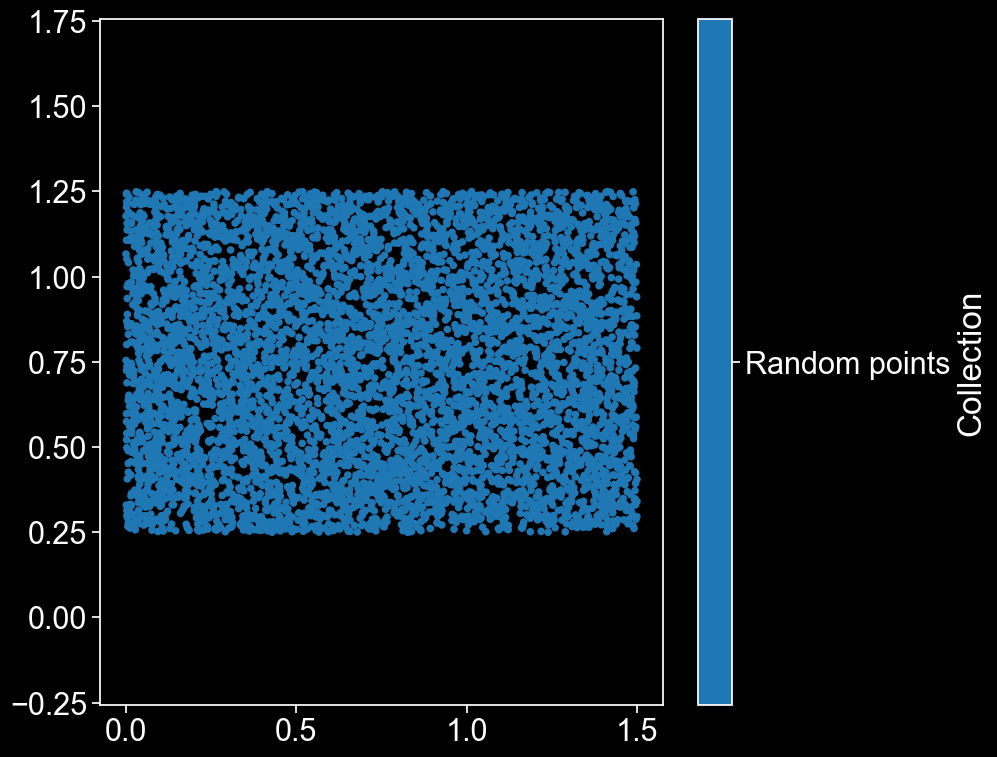

In [2]:
# Make an empty MuSpAn domain
domain = ms.domain('Logo')

# Generate random points with random labels
# Need aspect ratio 1:1.5 for newsletter, so we'll just generate points in [0,1.5]x[0,1.5] and then crop the top and bottom off
points = np.random.rand(10000,2)*1.5
to_del = (points[:,1] > 1.25) + (points[:,1] < 0.25)
points = points[~to_del,:]

# Add the points to the domain and visualise them
domain.add_points(points,'Random points')
ms.visualise.visualise(domain)

Beautiful. In a minute, we'll want to know which points are on the left and right hand sides, so we'll assign each point a label that tells us this. Points whose x coordinate is less than 0.65 will be on the LHS, and those with x greater than 0.85 will be on the RHS. Since we don't want a perfect cut down the middle (it'd be nice to have a transitionary region in which some points are part of the LHS and some part of the RHS), we'll assign points with $0.65 \leq x < 0.85$ to either the LHS or RHS randomly (with a probability proportionate to their $x$ coordinate, so that we get a relatively smooth transition).

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

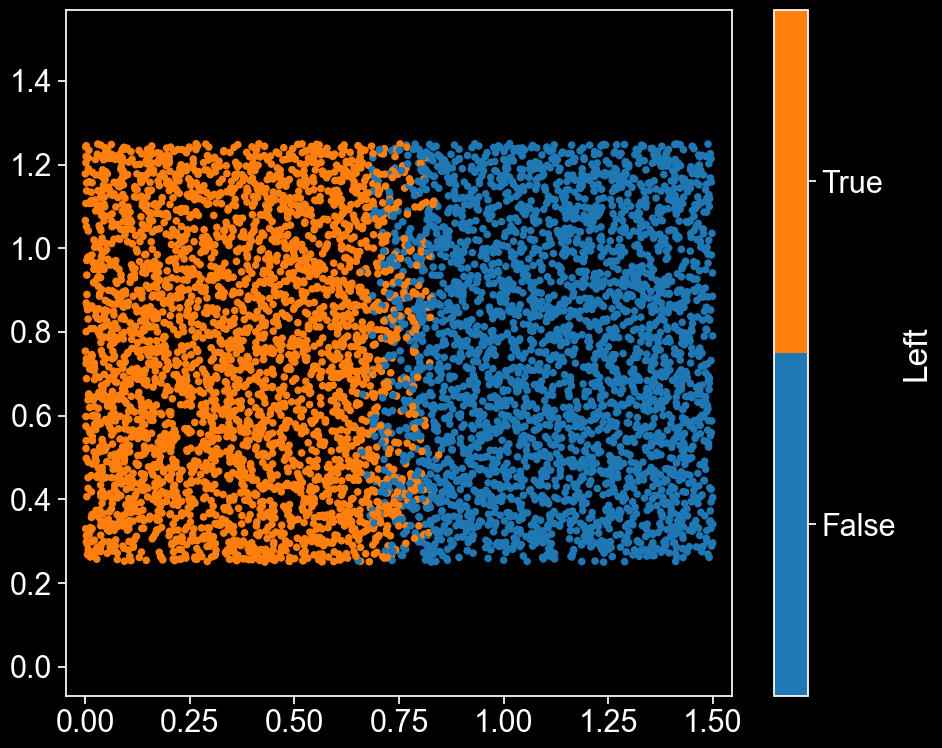

In [3]:
# Assign points a label describing whether they're on the left side of the domain or not
# Points in the central 0.2 of the domain will be randomly allocated to left or right, with bias based on how close to each side they are
mask = points[:,0]<0.65
middle = (points[:,0]<0.85)*~mask
flip_prob=0.5
mask[middle] = np.random.rand(len(mask[middle]))>((points[middle,0]-0.65)*5)
# Add the label to the domain
domain.add_labels('Left',mask)
# Take a look at which points we've assigned to the left hand side
ms.visualise.visualise(domain,'Left')

Great, now we can easily look at either the LHS or RHS points just by using the label. That'll come in handy later.

For now, let's focus on our giant $\mu$. Let's load in a .png image which contains the shape. We'll only need one colour channel, so we'll turn it into an array by taking only the blue colour channel. We only want the boundary of the shape to read it into MuSpAn, so we'll take the contours of this array.

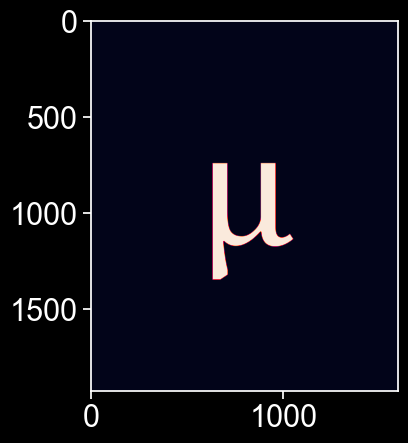

In [4]:
url = 'https://docs.muspan.co.uk/misc/mu_for_logo.png'
mu_logo = io.imread(url)
grayscale=mu_logo[:,:,3]
plt.imshow(grayscale)

# Take a threshold to convert the image data into a boundary shape
contours = measure.find_contours(grayscale, 200)
x,y=contours[0][:, 1], -contours[0][:, 0]

Now, rescale the shape so that it fits into our domain, and add it to the domain as a shape. Then visualise it so we can see everything all at once.

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

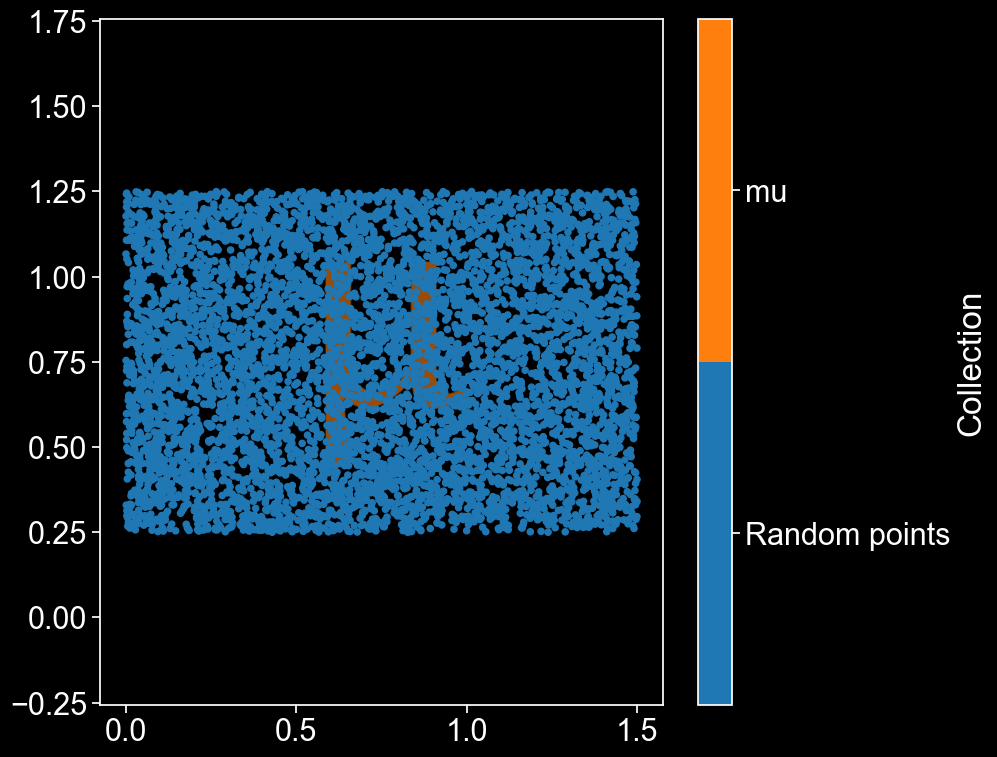

In [5]:
# Rescale the shape to fit over our points, and then add it to the domain
logo_scale=0.001
logo_points=np.array([x,y]).T
centre=np.mean(logo_points,axis=0)
logo_points=logo_scale*(logo_points-centre) + domain.boundary.centroid

# Add the shape to the domain
mu_ID = domain.add_shapes([logo_points],return_IDs=True,collection_name='mu')

# # Take a look at everything in the domain
ms.visualise.visualise(domain)

There's our $\mu$ shape, peeking out from behind all those lovely points! We can now easily define a MuSpAn query that gets all the points which are outside the $\mu$.

(<Figure size 1000x800 with 1 Axes>, <Axes: >)

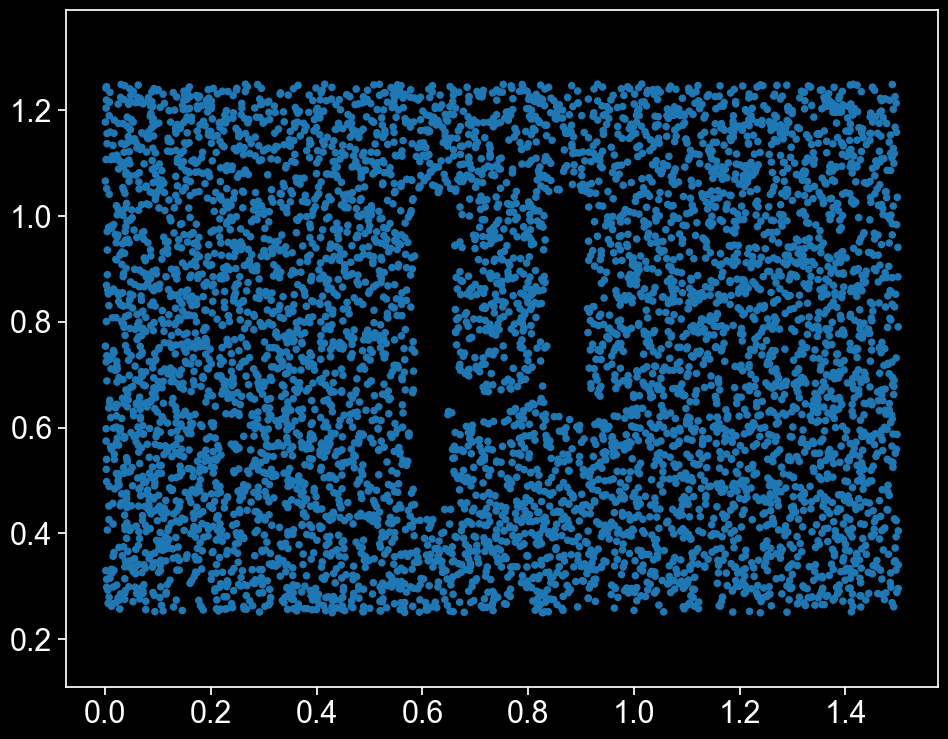

In [6]:
# Use MuSpAn's 'query' infrastructure to get only the points outside of the Mu
q_points = ms.query.query(domain,('object','type'),'is','point')
q = ms.query.query(domain,('contains',(q_points,mu_ID)),'is',False)

# Visualise them
ms.visualise.visualise(domain, objects_to_plot=q, add_cbar=False)

Now that we've got a shape, let's think about colour. There's a lot of different ways we could choose to colour our points. First, let's add a label that describes the distance of each point from $(x,y) = (0.75, 0.75)$, the middle of the domain.



(<Figure size 1000x800 with 1 Axes>, <Axes: >)

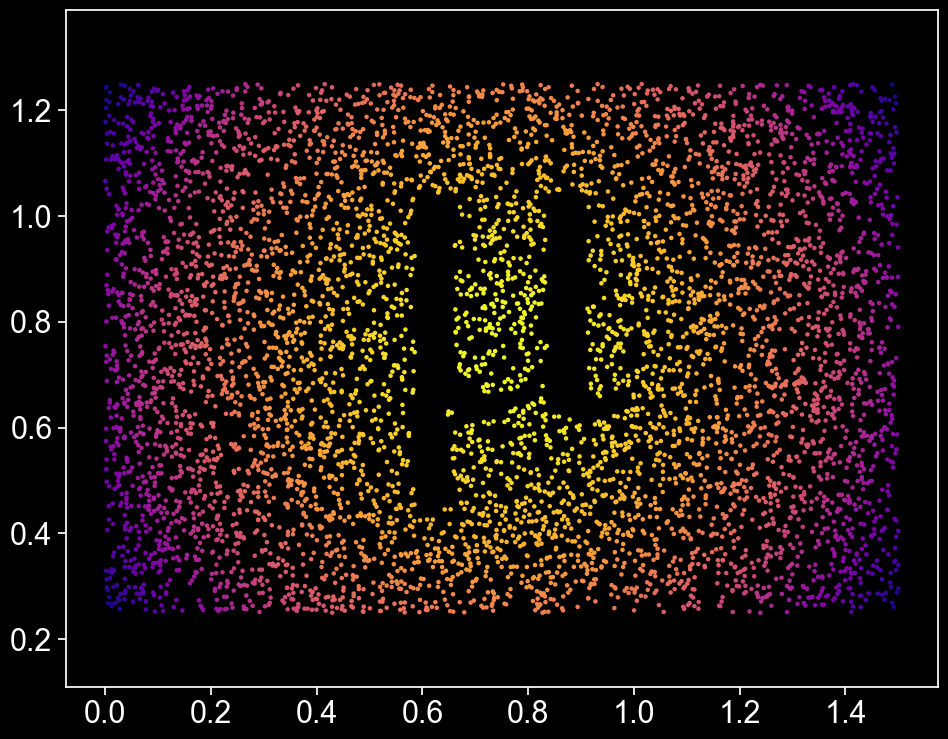

In [7]:
# Add a smoothly varying label describing distance from the centre of the image
dist = np.sum((points - [0.75,0.75])**2,axis=1)
domain.add_labels('Dist',dist,add_labels_to=q_points,cmap='plasma_r')
ms.visualise.visualise(domain,'Dist',objects_to_plot=q,marker_size=5,add_cbar=False)

Gorgeous! For another interpretation, we'll create a Delaunay network on all of the points that aren't inside the $\mu$, and weight each edge according to how long it is.

(<Figure size 1000x800 with 1 Axes>, <Axes: >)

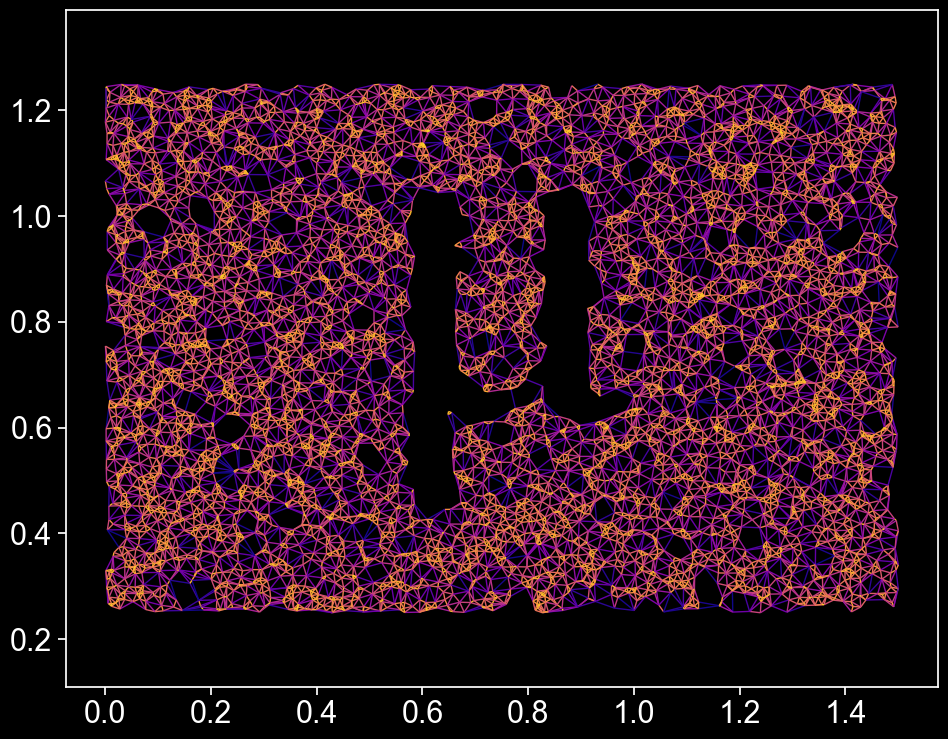

In [8]:
# Construct a weighted Delaunay network on the RHS points, weighted by edge length
ms.networks.generate_network(domain,objects_as_nodes=q,network_name='Net',network_type='Delaunay',max_edge_distance=0.04)
ms.visualise.visualise_network(domain,'Net',edge_weight_name='Distance',visualise_kwargs={'objects_to_plot':q,'marker_size':0,'add_cbar':False},edge_cmap='plasma_r',add_cbar=False)

Nice! And to finish, let's combine this with our Left/Right label from earlier to get the final artwork.

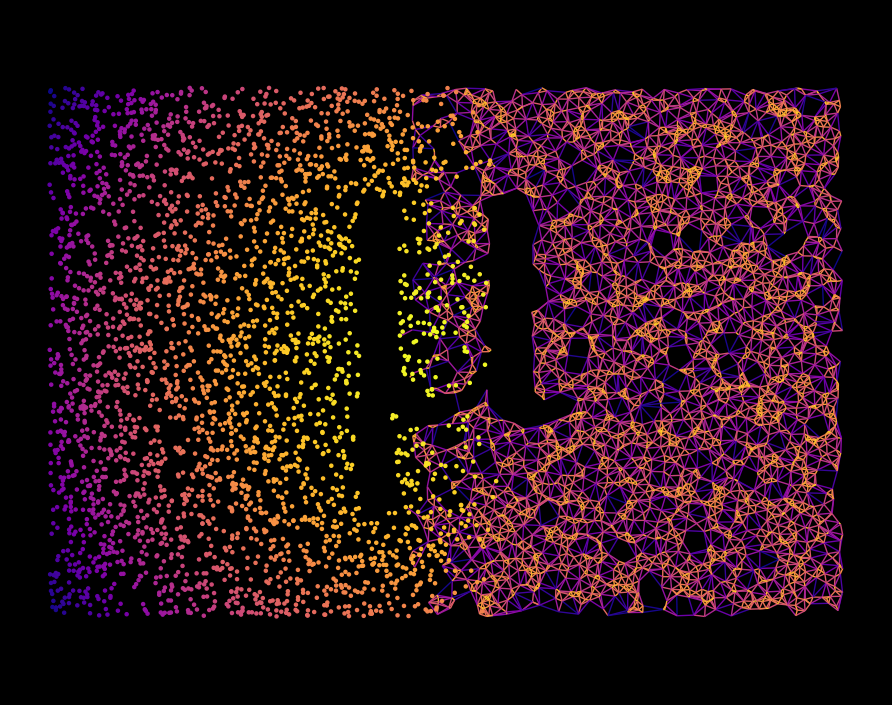

In [9]:
# Now combine the two - show the points for cells on the Left, and the network for those on the right
# 50:50
qA = ms.query.query_container(q,'AND',ms.query.query(domain,('label','Left'),'is',True),domain=domain)
qB = ms.query.query_container(q,'AND',ms.query.query(domain,('label','Left'),'is',False),domain=domain)

# Construct a weighted Delaunay network on the RHS points, weighted by edge length
ms.networks.generate_network(domain,objects_as_nodes=qB,network_name='Net',network_type='Delaunay',max_edge_distance=0.04)

# Visualise the LHS objects, coloured by distance to centre
ms.visualise.visualise(domain,'Dist',objects_to_plot=qA,marker_size=5,add_cbar=False)
# Visualise the RHS network on the same axis. Set point size to 0 so we only see the edges. Colour them by edge length
ms.visualise.visualise_network(domain,'Net',edge_weight_name='Distance',visualise_kwargs={'objects_to_plot':qB,'marker_size':0,'add_cbar':False},edge_cmap='plasma_r',ax=plt.gca(),add_cbar=False)
# Turn off the tick labels
plt.gca().set_axis_off()
